In [1]:
import torch
import os
import random
import numpy as np
import pytorch_lightning as pl

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from dataset.utils import process_classification_dataset

config = {
        'dataset': 'facebook_ct1', # 'infectious_ct1', #
        'hidden_size': 32,
        'rnn_layers': 8,
        'readout_layers': 3,
        'cell_type': 'lstm',
        'dim_red': 64,
        'add_self_loops': False,
        'verbose': True,
        'cat_states_layers': True,
        'weight_decay': 1e-3,
        'step_size': 30,
        'gamma': 0.5
        }

# Select one GPU if more are available
os.environ["CUDA_VISIBLE_DEVICES"]='0'

seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
pl.seed_everything(seed)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Seed set to 42


In [2]:
# Fix cuda memory issue
dataset, states, node_states = process_classification_dataset(config, "DynCRNN", device)

100%|██████████| 995/995 [11:40<00:00,  1.42it/s]


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

inputs, test_inputs, labels, test_labels = train_test_split(states.inputs[:,-1,:], dataset.targets, test_size=0.2, random_state=seed)

# Create the classifier
classifier = LogisticRegression(max_iter=5000, random_state=seed)

# Train the classifier
classifier.fit(inputs, labels)

# Test the classifier
y_pred = classifier.predict(test_inputs)

accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9547738693467337


# PCA

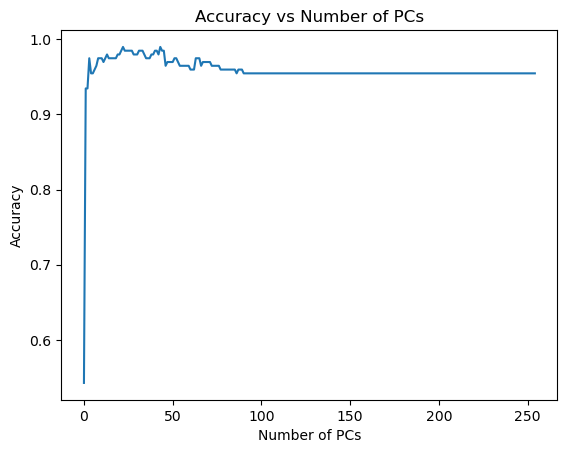

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

train_X, val_X, train_y, val_y = train_test_split(states.inputs, states.targets, test_size=0.2, random_state=seed)

accs = []
for dim_red in range(1, train_X.shape[-1]):
    pca = PCA(n_components=dim_red)
    train_X_red = pca.fit_transform(train_X[:,-1,:])
    val_X_red = pca.transform(val_X[:,-1,:])

    classifier = LogisticRegression(max_iter=5000, random_state=seed)
    classifier.fit(train_X_red, train_y)
    y_pred = classifier.predict(val_X_red)
    accs.append(accuracy_score(val_y, y_pred))

accs = np.array(accs)

plt.plot(accs)
plt.xlabel('Number of PCs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of PCs')
plt.show()

Check which PC contains more information

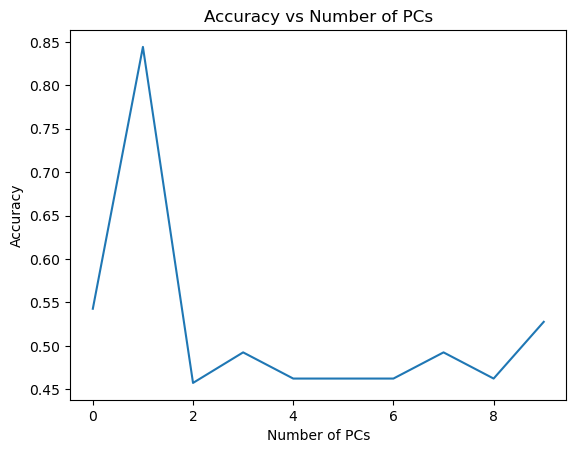

In [5]:
accs = []

pca2 = PCA(n_components=10)
train_X_red2 = pca2.fit_transform(train_X[:,-1,:])
val_X_red2 = pca2.transform(val_X[:,-1,:])

for i in range(0, train_X_red2.shape[-1]):
    x = train_X_red2[:,i]
    x = x[:, np.newaxis]
    classifier2 = LogisticRegression(max_iter=5000, random_state=seed)
    classifier2.fit(x, train_y)
    x = val_X_red2[:,i]
    x = x[:, np.newaxis]
    y_pred = classifier2.predict(x)
    accs.append(accuracy_score(val_y, y_pred))

accs = np.array(accs)

plt.plot(accs)
plt.xlabel('Number of PCs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of PCs')
plt.show()

The second one!

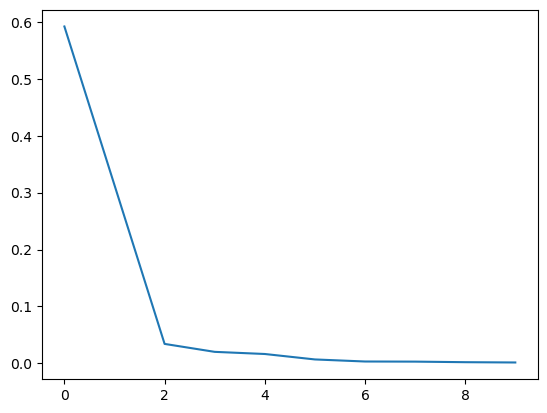

In [6]:
plt.plot(pca2.explained_variance_ratio_)

Is it always the second PC?

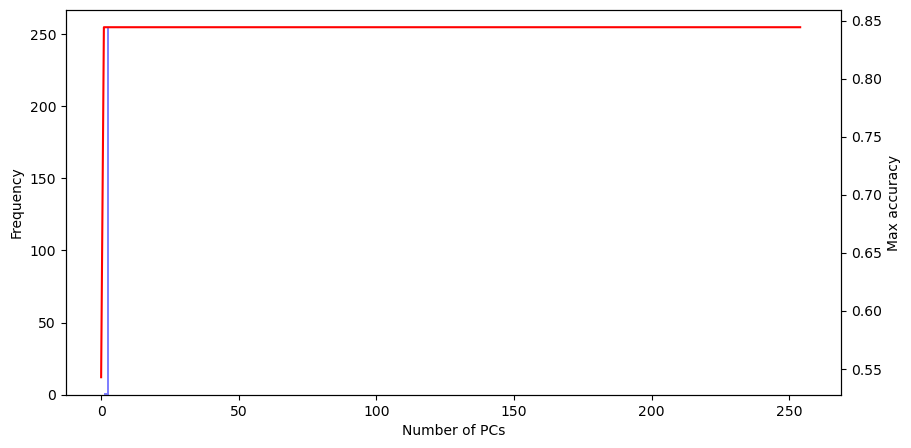

In [7]:
pc = []
max_accs = []

for dim_red in range(1, train_X.shape[-1]):
    pca3 = PCA(n_components=dim_red)
    train_X_red3 = pca3.fit_transform(train_X[:,-1,:])
    val_X_red3 = pca3.transform(val_X[:,-1,:])
    accs = []

    for i in range(0, train_X_red3.shape[-1]):
        x = train_X_red3[:,i]
        x = x[:, np.newaxis]
        classifier4 = LogisticRegression(max_iter=5000, random_state=seed)
        classifier4.fit(x, train_y)
        x = val_X_red3[:,i]
        x = x[:, np.newaxis]
        y_pred = classifier4.predict(x)
        accs.append(accuracy_score(val_y, y_pred))

    accs = np.array(accs)
    pc.append(np.argmax(accs) + 1)
    max_accs.append(np.max(accs))

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.hist(pc, bins=train_X.shape[-1], range=(0, train_X.shape[-1]), alpha=0.5, color='blue')
ax1.set_ylabel('Frequency')

ax2 = ax1.twinx()
ax2.plot(max_accs, color='red')
ax2.set_ylabel('Max accuracy')
ax1.set_xlabel('Number of PCs')

plt.show()

In [8]:
max(set(pc), key=pc.count)

2

Let's check how the two classes separate in the first three PC when doing dimensionality reduction to 10

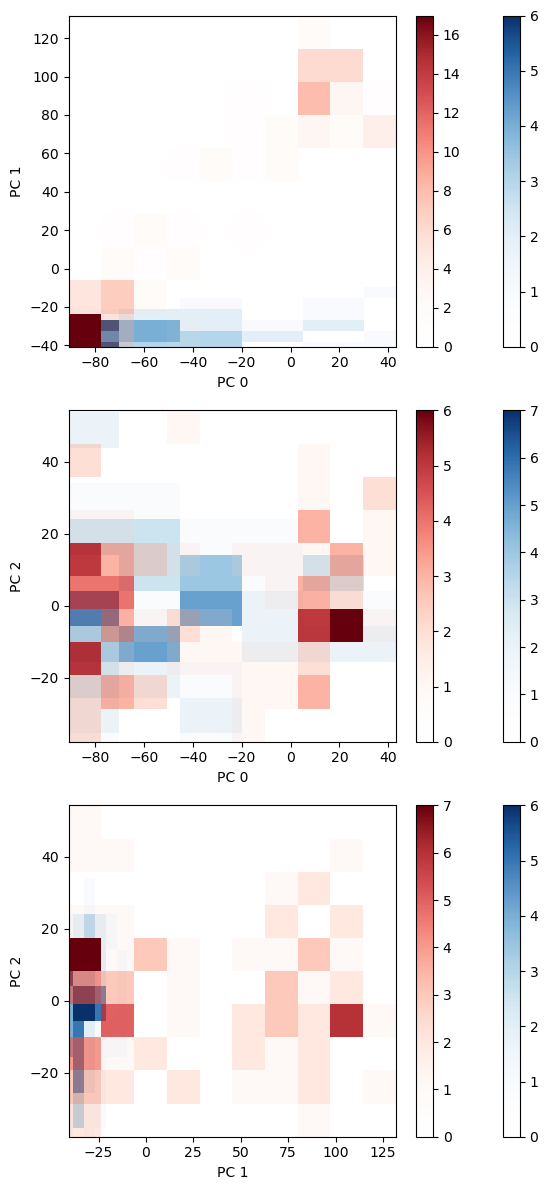

In [9]:
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap

idx0 = val_y == 0
idx1 = val_y == 1
label_0 = val_X_red2[idx0]
label_1 = val_X_red2[idx1]

# modify existing Reds colormap with a linearly fading alpha
red = pl.cm.Reds  # original colormap
fading_red = red(np.arange(red.N)) # extract colors
fading_red[:, -1] = np.linspace(0, 1, red.N) # modify alpha
fading_red = ListedColormap(fading_red) # convert to colormap

blue = pl.cm.Blues  # original colormap
fading_blue = blue(np.arange(blue.N)) # extract colors
fading_blue[:, -1] = np.linspace(0, 1, blue.N) # modify alpha
fading_blue = ListedColormap(fading_blue) # convert to colormap

# Create a figure with two subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 12))

# PC0 vs PC1
# Plot the first histogram in the first subplot
hist1 = axs[0].hist2d(label_0[:, 0], label_0[:, 1], bins=10, cmap=fading_blue, label='Label 0')
hist2 = axs[0].hist2d(label_1[:, 0], label_1[:, 1], bins=10, cmap=fading_red, label='Label 1')
axs[0].set_xlabel('PC 0')
axs[0].set_ylabel('PC 1')
plt.colorbar(hist1[3], ax=axs[0])
plt.colorbar(hist2[3], ax=axs[0])

# PC0 vs PC2
# Plot the first histogram in the first subplot
hist3 = axs[1].hist2d(label_0[:, 0], label_0[:, 2], bins=10, cmap=fading_blue, label='Label 0')
hist4 = axs[1].hist2d(label_1[:, 0], label_1[:, 2], bins=10, cmap=fading_red, label='Label 1')
axs[1].set_xlabel('PC 0')
axs[1].set_ylabel('PC 2')
plt.colorbar(hist3[3], ax=axs[1])
plt.colorbar(hist4[3], ax=axs[1])

# PC1 vs PC2
# Plot the first histogram in the first subplot
hist5 = axs[2].hist2d(label_0[:, 1], label_0[:, 2], bins=10, cmap=fading_blue, label='Label 0')
hist6 = axs[2].hist2d(label_1[:, 1], label_1[:, 2], bins=10, cmap=fading_red, label='Label 1')
axs[2].set_xlabel('PC 1')
axs[2].set_ylabel('PC 2')
plt.colorbar(hist5[3], ax=axs[2])
plt.colorbar(hist6[3], ax=axs[2])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [10]:
import plotly.express as px
import pandas as pd

# Create a DataFrame for label_1 and label_0 data
df_label_0 = pd.DataFrame(label_0[:,[0,1,2]], columns=['PC0', 'PC1', 'PC2'])
df_label_1 = pd.DataFrame(label_1[:,[0,1,2]], columns=['PC0', 'PC1', 'PC2'])

# Add a column to indicate the label
df_label_0['label'] = 'Label 0'
df_label_1['label'] = 'Label 1'

# Concatenate the dataframes
df = pd.concat([df_label_0, df_label_1])

# Create the 3D scatter plot
fig = px.scatter_3d(df, x='PC0', y='PC1', z='PC2', color='label')

# Show the plot
fig.show()

There is a strong separation in PC1. Is it showing a linear attractor?

Let's plot some trajectories as well

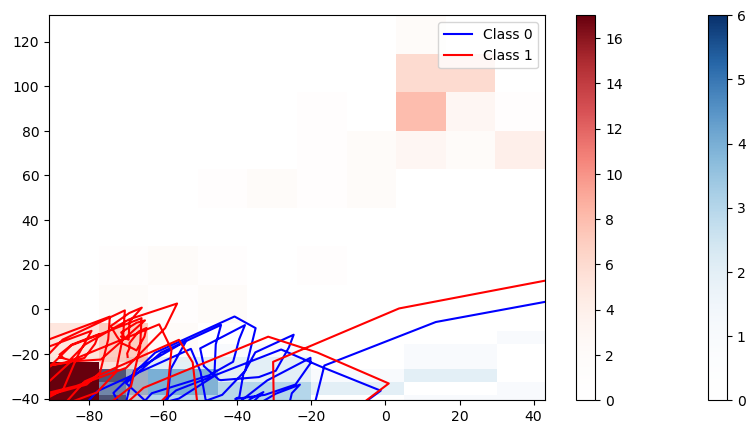

In [11]:
from einops import rearrange

val_proj20 = val_X_red2[~val_y.astype(bool)]
val_proj21 = val_X_red2[val_y.astype(bool)]

fig, ax = plt.subplots(figsize=(10, 5))

hist0 = ax.hist2d(val_proj20[:,0], val_proj20[:,1], bins=10, cmap=fading_blue)
hist1 = ax.hist2d(val_proj21[:,0], val_proj21[:,1], bins=10, cmap=fading_red)

plt.colorbar(hist0[3], ax=ax)
plt.colorbar(hist1[3], ax=ax)

# add one full trajectory for each class
val_X_rearr = rearrange(val_X, 'b t f -> (b t) f')
val_X_redt = pca2.transform(val_X_rearr)
val_X_redt = rearrange(val_X_redt, '(b t) f -> b t f', b = val_X.shape[0], t=val_X.shape[1], f=10)

traj0 = val_X_redt[1]
traj1 = val_X_redt[0]

ax.plot(traj0[:,0], traj0[:,1], c='blue', label='Class 0')
ax.plot(traj1[:,0], traj1[:,1], c='red', label='Class 1')

# Show the plot
plt.legend()
plt.show()

Average trajectories:

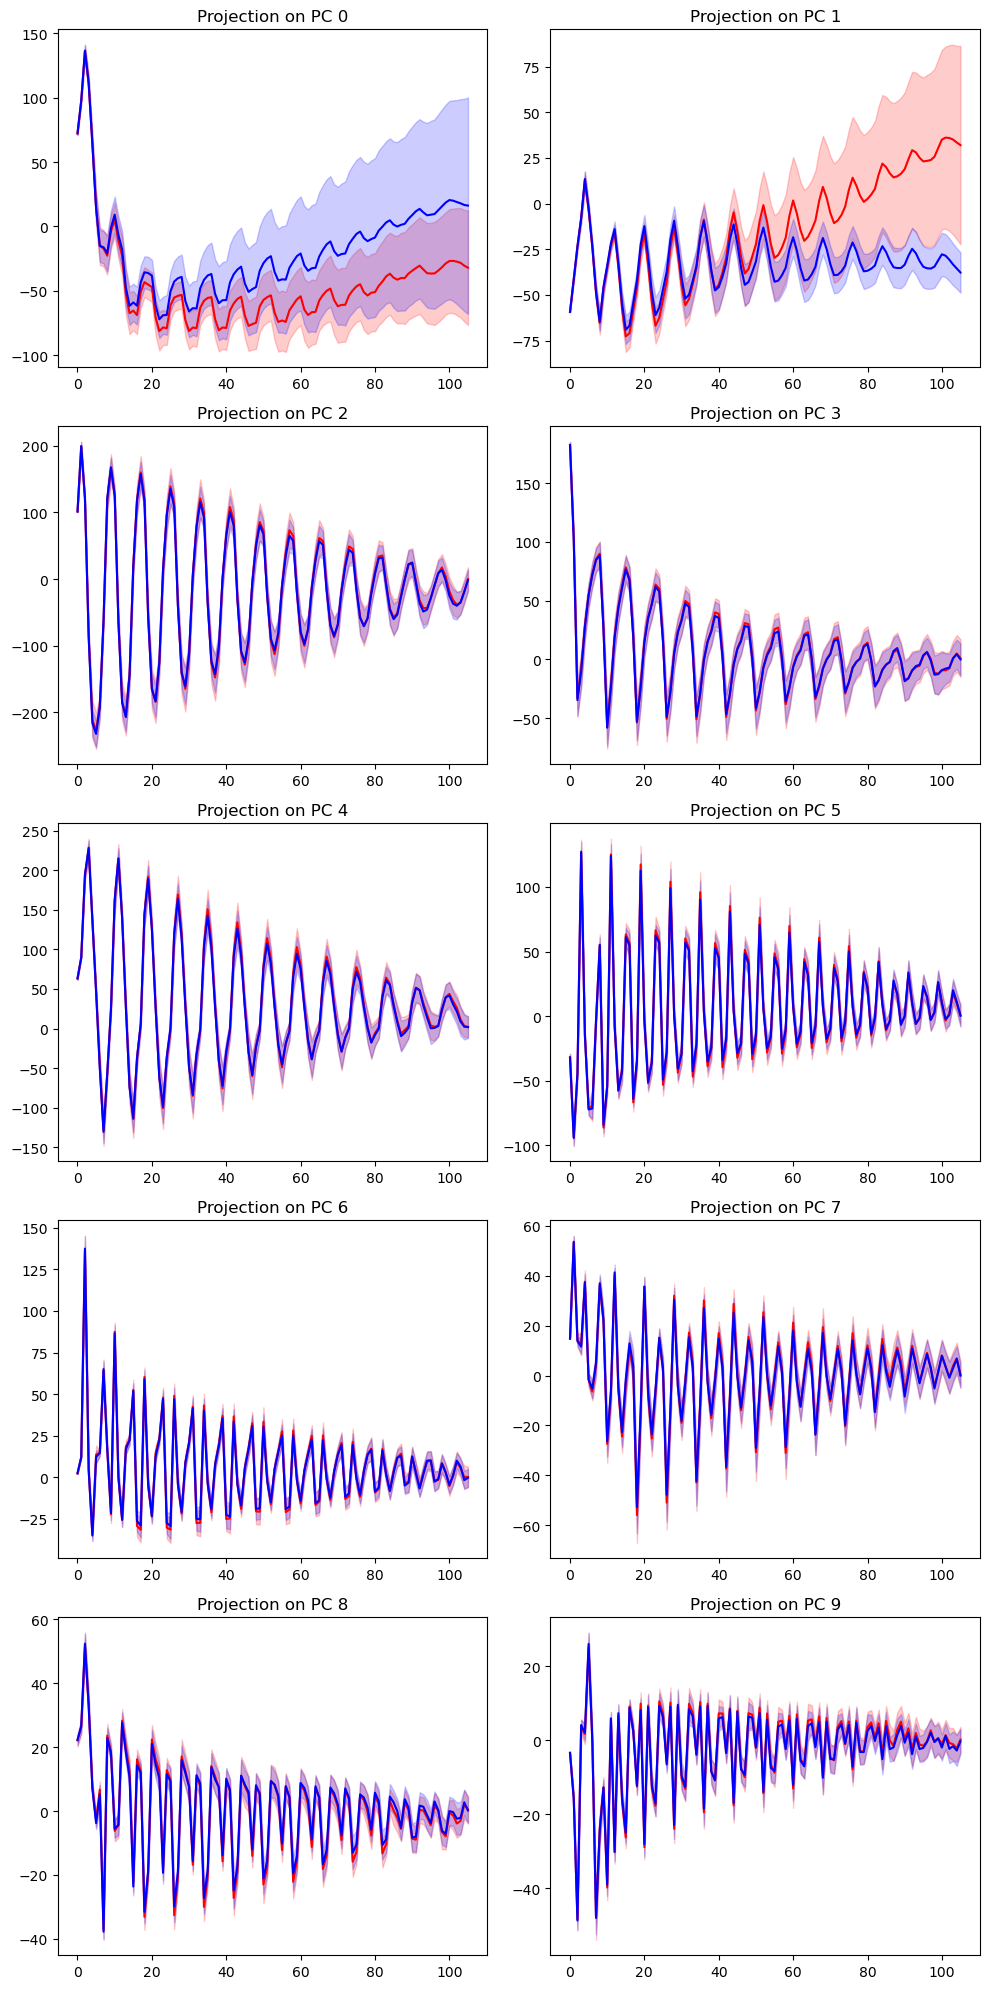

In [12]:
fig, axs = plt.subplots(5, 2, figsize=(10, 20))

for i in range(10):
    val_proj = val_X_redt[:,:,i]

    m = val_proj[val_y.astype(bool)].mean(axis=0)
    s = val_proj[val_y.astype(bool)].std(axis=0)
    m_not = val_proj[~val_y.astype(bool)].mean(axis=0)
    s_not = val_proj[~val_y.astype(bool)].std(axis=0)

    axs[i//2, i%2].plot(m, c='r', label="class 1")
    axs[i//2, i%2].fill_between(np.arange(m.shape[0]), m-s, m+s, color='r', alpha=0.2)
    axs[i//2, i%2].plot(m_not, c='b', label="class 0")
    axs[i//2, i%2].fill_between(np.arange(m.shape[0]), m_not-s_not, m_not+s_not, color='b', alpha=0.2)
    axs[i//2, i%2].set_title(f'Projection on PC {i}')

    # axs[i//2, i%2].set_ylim(-10,10)


# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# DMD

In [13]:
from DMD.dmd import KANN

dim_red = 10
method = 'PCA'

# compute local Koopman operator
kann_ = KANN(train_X, k=dim_red, emb=method)

K0 = kann_.compute_KOP()

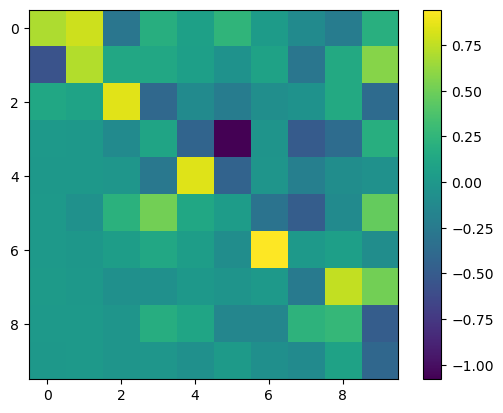

In [14]:
plt.imshow(K0)
plt.colorbar()

/tmp/ipykernel_2231786/1226691090.py:8: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



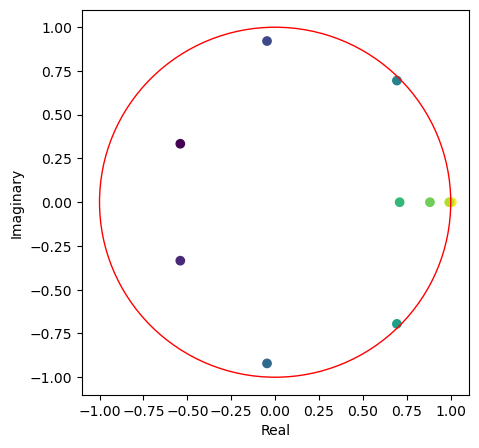

In [15]:
E, V = np.linalg.eig(K0)

# sort eigenvalues and eigenvectors
idx = np.argsort(np.abs(E))[::-1]
E = E[idx]
V = V[:, idx]

cmap = plt.cm.get_cmap('viridis')

plt.figure(figsize=(5,5))
plt.scatter(E.real, E.imag, c=idx, cmap=cmap)
circle = plt.Circle((0, 0), 1, color='r', fill=False)
plt.gca().add_patch(circle)
plt.ylabel('Imaginary') 
plt.xlabel('Real')
plt.show()

In [16]:
E

array([ 1.0060655 +0.j        ,  0.9914735 +0.j        ,
        0.6935148 -0.69519967j,  0.6935148 +0.69519967j,
       -0.04615879-0.9210587j , -0.04615879+0.9210587j ,
        0.88174045+0.j        ,  0.70916885+0.j        ,
       -0.53994197-0.33406827j, -0.53994197+0.33406827j], dtype=complex64)

In [17]:
abs(E)

array([1.0060655 , 0.9914735 , 0.98197013, 0.98197013, 0.92221457,
       0.92221457, 0.88174045, 0.70916885, 0.6349322 , 0.6349322 ],
      dtype=float32)

Project states on first two eigenvectors (they are real)

In [18]:
v12 = V[:,0:2].real

# Calculate the projection
val_X_red2 = kann_.emb_engine.transform(val_X_rearr)
val_X_red2 = rearrange(val_X_red2, '(b t) f -> b t f', b = val_X.shape[0], t=val_X.shape[1], f=dim_red)
val_X_proj = np.dot(val_X_red2, v12)


In [19]:
val_X_proj.shape

(199, 106, 2)

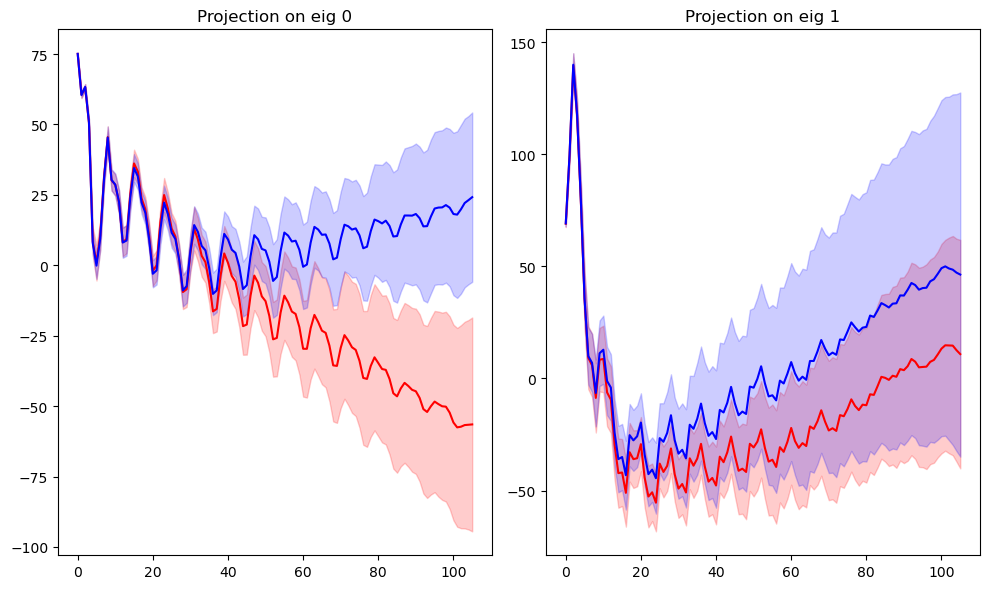

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

for i in range(2):
    val_proj = val_X_proj[:,:,i]

    m = val_proj[val_y.astype(bool)].mean(axis=0)
    s = val_proj[val_y.astype(bool)].std(axis=0)
    m_not = val_proj[~val_y.astype(bool)].mean(axis=0)
    s_not = val_proj[~val_y.astype(bool)].std(axis=0)

    axs[i%2].plot(m, c='r', label="class 1")
    axs[i%2].fill_between(np.arange(m.shape[0]), m-s, m+s, color='r', alpha=0.2)
    axs[i%2].plot(m_not, c='b', label="class 0")
    axs[i%2].fill_between(np.arange(m.shape[0]), m_not-s_not, m_not+s_not, color='b', alpha=0.2)
    axs[i%2].set_title(f'Projection on eig {i}')

    # axs[i//2, i%2].set_ylim(-10,10)


# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [21]:
v12

array([[-0.08477847, -0.01241172],
       [ 0.02901104,  0.27540258],
       [ 0.25886852,  0.7741118 ],
       [-0.03570212, -0.3498921 ],
       [-0.49960008,  0.41500315],
       [ 0.26237658,  0.0945425 ],
       [-0.77404124, -0.11795935],
       [-0.02877466, -0.06505963],
       [-0.0392601 , -0.05267012],
       [ 0.06109475, -0.01544583]], dtype=float32)

In [22]:
val_X.shape

(199, 106, 256)

In [23]:
val_X_red2.shape

(199, 106, 10)

Focus on two trajectories pushed forward in time with the Koopman operator

In [24]:
val_X_rec0 = np.empty_like(val_X_red2[0])
val_X_rec1 = np.empty_like(val_X_red2[1])

for n in range(val_X_red2.shape[1]):
    val_X_rec0[n] = np.dot(val_X_red2[0][0], K0**n)
    val_X_rec1[n] = np.dot(val_X_red2[1][0], K0**n)
    

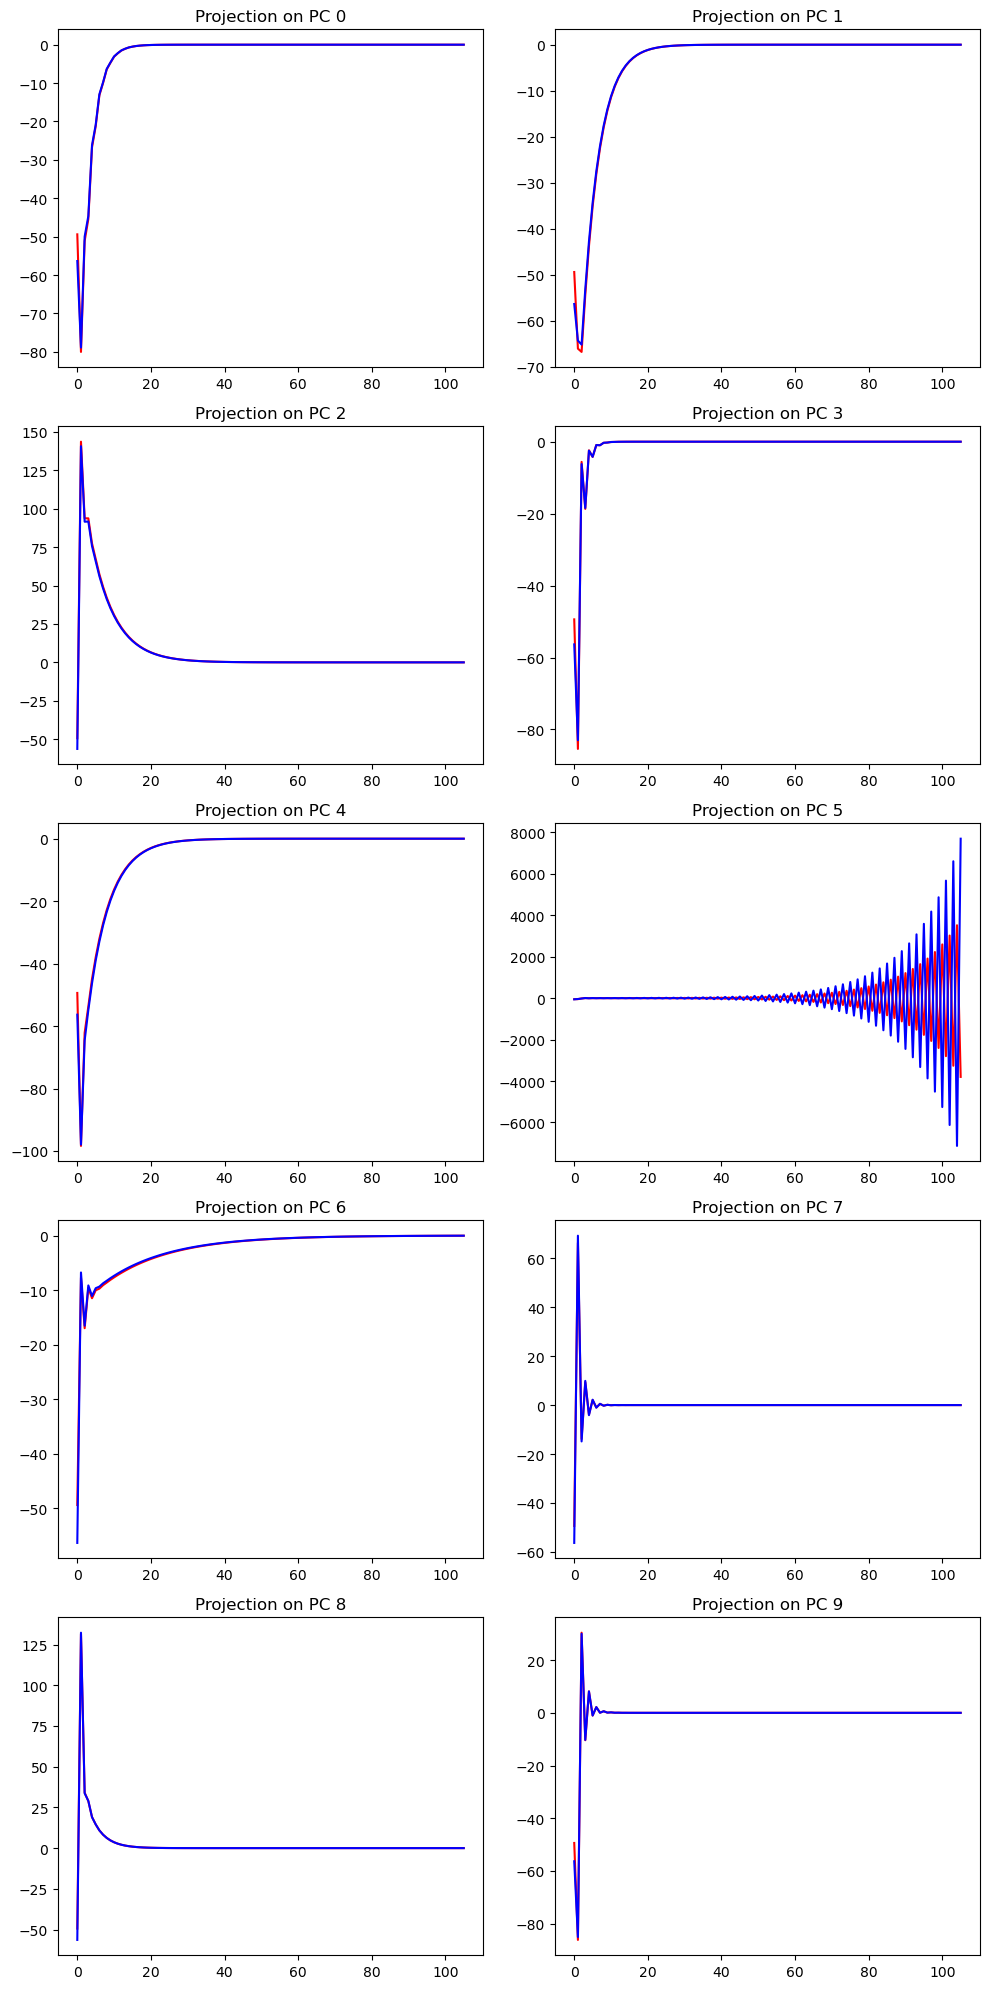

In [25]:
fig, axs = plt.subplots(5, 2, figsize=(10, 20))

for i in range(10):
    val_proj0 = val_X_rec0[:,i]
    val_proj1 = val_X_rec1[:,i]

    axs[i//2, i%2].plot(val_proj0, c='r', label="class 1")
    axs[i//2, i%2].plot(val_proj1, c='b', label="class 0")
    axs[i//2, i%2].set_title(f'Projection on PC {i}')

    # axs[i//2, i%2].set_ylim(-10,10)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [26]:
node_states[0].shape

torch.Size([106, 100, 256])

In [27]:
len(node_states)

995

Check if there's some correspondence between projected states and ground truth

In [28]:
val_X_proj.shape

(199, 106, 2)

In [29]:
from dataset.utils import ground_truth

nodes_gt, node_sums_gt, times_gt = ground_truth("facebook_ct1")

995it [00:05, 172.28it/s]


In [30]:
train_node_sums_gt, val_node_sums_gt, train_times_gt, val_times_gt = train_test_split(np.array(node_sums_gt), np.array(times_gt), test_size=0.2, random_state=seed)

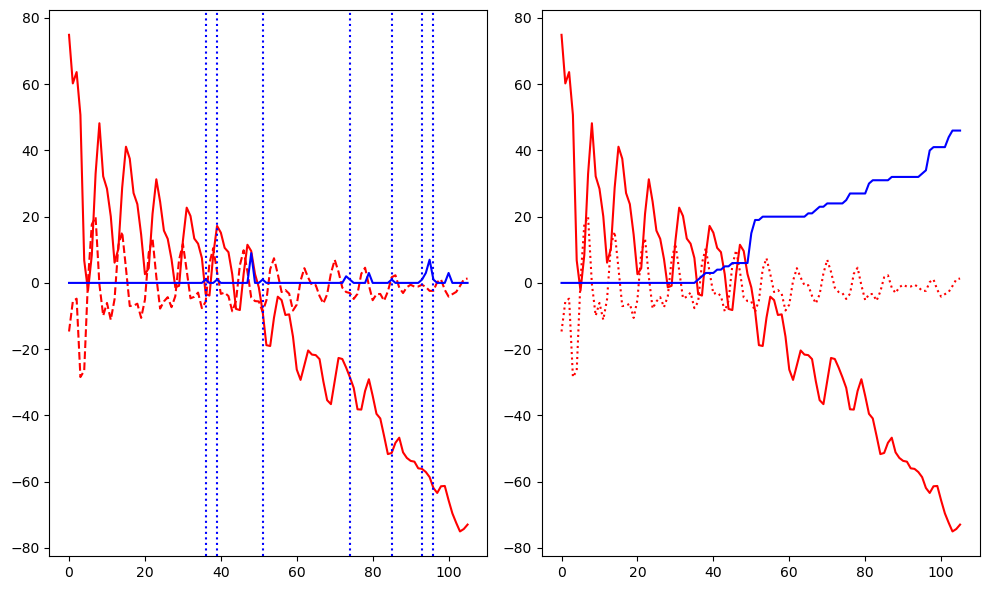

1.0


In [31]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

val_proj = val_X_proj[:,:,0]
der_val_proj = np.gradient(val_proj, axis=1)
idx = 7

axs[0].plot(val_proj[idx], c='r', label="Proj trajectory")
axs[0].plot(der_val_proj[idx], c='r', linestyle='dashed', label="Derivative")
axs[0].plot(val_times_gt[idx], c='b', label="Time GT")

idx_t = np.where(val_times_gt[idx] == 1)[0]
for i in idx_t:
    axs[0].axvline(x=i, color='b', linestyle='dotted')

axs[1].plot(val_proj[idx], c='r', label="Proj trajectory")
axs[1].plot(der_val_proj[idx], c='r', linestyle='dotted', label="Derivative")
axs[1].plot(val_node_sums_gt[idx], c='b', label="Node sums GT")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

print(val_y[idx])

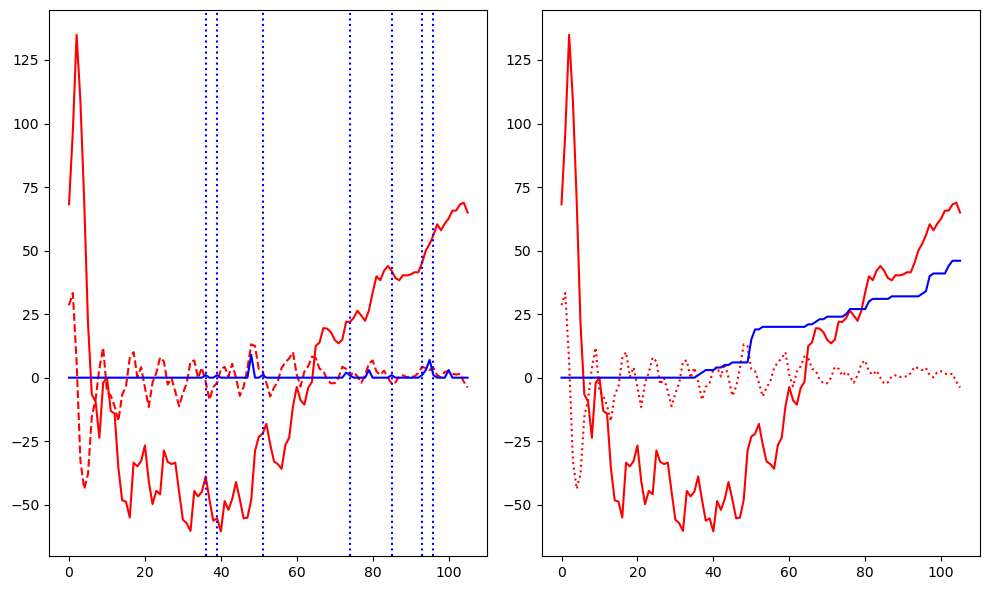

1.0


In [32]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

val_proj = val_X_proj[:,:,1]
der_val_proj = np.gradient(val_proj, axis=1)
idx = 7

axs[0].plot(val_proj[idx], c='r', label="Proj trajectory")
axs[0].plot(der_val_proj[idx], c='r', linestyle='dashed', label="Derivative")
axs[0].plot(val_times_gt[idx], c='b', label="Time GT")

idx_t = np.where(val_times_gt[idx] == 1)[0]
for i in idx_t:
    axs[0].axvline(x=i, color='b', linestyle='dotted')

axs[1].plot(val_proj[idx], c='r', label="Proj trajectory")
axs[1].plot(der_val_proj[idx], c='r', linestyle='dotted', label="Derivative")
axs[1].plot(val_node_sums_gt[idx], c='b', label="Node sums GT")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

print(val_y[idx])

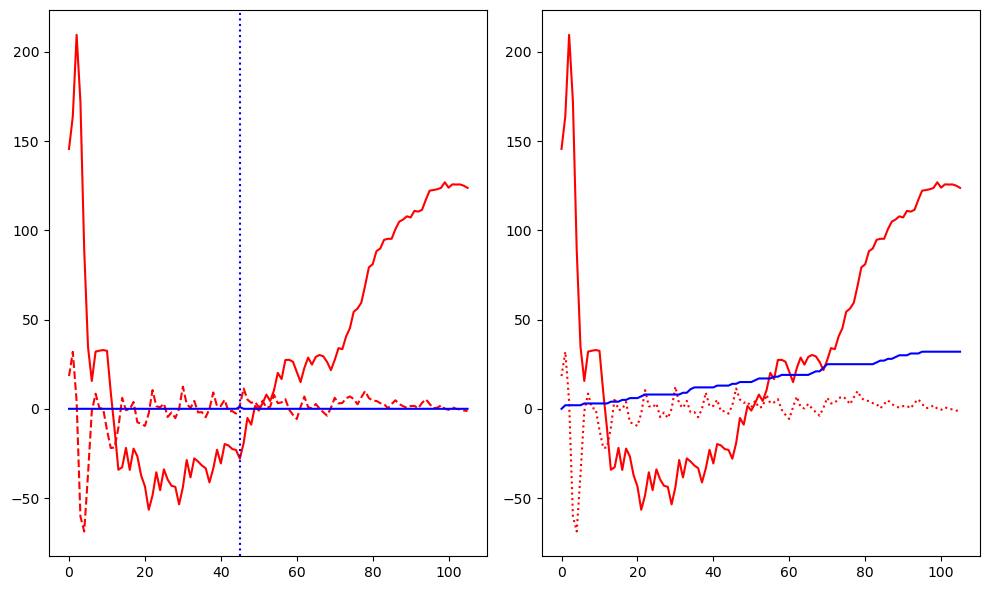

0.0


In [33]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

val_proj = val_X_proj[:,:,0] + val_X_proj[:,:,1]
der_val_proj = np.gradient(val_proj, axis=1)
idx = 2

axs[0].plot(val_proj[idx], c='r', label="Proj trajectory")
axs[0].plot(der_val_proj[idx], c='r', linestyle='dashed', label="Derivative")
axs[0].plot(val_times_gt[idx], c='b', label="Time GT")

idx_t = np.where(val_times_gt[idx] == 1)[0]
for i in idx_t:
    axs[0].axvline(x=i, color='b', linestyle='dotted')

axs[1].plot(val_proj[idx], c='r', label="Proj trajectory")
axs[1].plot(der_val_proj[idx], c='r', linestyle='dotted', label="Derivative")
axs[1].plot(val_node_sums_gt[idx], c='b', label="Node sums GT")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

print(val_y[idx])

Explore more systematically if there is any correlation with GT

In [34]:
from models.DynGraphConvRNN import DynGraphModel

input_size = 1
model = DynGraphModel(input_size=input_size,
                        hidden_size=config['hidden_size'],
                        rnn_layers=config['rnn_layers'],
                        readout_layers=config['readout_layers'],
                        cell_type=config['cell_type'],
                        cat_states_layers=config['cat_states_layers']).to(device)

# Load the model from the file
model_filepath = f'models/saved/dynConvRNN_{config["dataset"]}.pt'
if not os.path.exists(model_filepath):
    raise FileNotFoundError(f"Model file '{model_filepath}' not found. Train the model first.")
model.load_state_dict(torch.load(model_filepath))
model = model.to(device)
model.eval()

DynGraphModel(
  (encoder): DynGraphConvRNN(cell=GraphConvLSTMCell, return_only_last_state=False)
  (readout): ModuleList(
    (0-1): 2 x Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [35]:
model.readout[-1]

Linear(in_features=256, out_features=1, bias=True)